### EDA analysis for proliferation

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from src.auxiliar_functions import AuxFunctions
import numpy as np
import math
import string
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap

In [3]:
# Global style (paper-friendly)
plt.rcParams.update({
    "font.size": 11,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
    "axes.linewidth": 1.0,
})

In [4]:
df_proliferation = pd.read_excel("../raw_data/KI67.xlsx")
df_proliferation.head()

,Cell line,Enzyme,Treatment (%),Ki67-positive cells (% of control)
0,RQ,ASNase,0,100.000000
1,RQ,ASNase,50,27.987743
2,RQ,ASNase,70,12.257406
3,RQ,ASNase,90,80.592441
4,RQ,GLNase,0,100.000000


In [5]:
df_to_process = df_proliferation.copy()
df_to_process["Enzyme"] = df_to_process["Enzyme"].astype(str).str.strip()
df_to_process["Treatment (%)"] = pd.to_numeric(df_to_process["Treatment (%)"], errors="coerce")
df_to_process["Ki67-positive cells (% of control)"] = pd.to_numeric(df_to_process["Ki67-positive cells (% of control)"], errors="coerce")
df_to_process = df_to_process.dropna(subset=["Cell line", "Enzyme", "Treatment (%)", "Ki67-positive cells (% of control)"])
df_to_process.head()

,Cell line,Enzyme,Treatment (%),Ki67-positive cells (% of control)
0,RQ,ASNase,0,100.000000
1,RQ,ASNase,50,27.987743
2,RQ,ASNase,70,12.257406
3,RQ,ASNase,90,80.592441
4,RQ,GLNase,0,100.000000


In [6]:
# Canonical order for treatments
treat_order = [0, 50, 70, 90]
present_treats = [t for t in treat_order if t in set(df_to_process["Treatment (%)"].unique())]
if len(present_treats) < 2:
    raise ValueError("Not enough distinct treatment levels found.")

In [7]:
df_to_process["Treatment (%)"] = pd.Categorical(df_to_process["Treatment (%)"], categories=present_treats, ordered=True)

In [8]:
enzyme_order = [
    "ASNase",
    "ADI",
    "GLNase",
    "GO",
    "SDH"]

present_enzymes = list(df_to_process["Enzyme"].unique())
enzyme_order = [e for e in enzyme_order if e in present_enzymes] + [e for e in present_enzymes if e not in enzyme_order]

In [9]:
summary = (
    df_to_process.groupby(["Enzyme", "Treatment (%)"], as_index=False)
           .agg(
               mean_proliferation=("Ki67-positive cells (% of control)", "mean"),
               sd_proliferation=("Ki67-positive cells (% of control)", "std"),
               n=("Ki67-positive cells (% of control)", "size"),
           )
           .sort_values(["Enzyme", "Treatment (%)"])
)

summary.head()

,Enzyme,Treatment (%),mean_proliferation,sd_proliferation,n
0,ADI,0,100.000000,0.000000,3
1,ADI,50,88.919889,49.039856,3
2,ADI,70,77.344457,69.783879,3
3,ADI,90,80.293088,19.566906,3
4,ASNase,0,100.000000,0.000000,3


In [10]:
pastel_blue = {
    0:  "#F2F6FB",
    50: "#D6E4F5",
    70: "#9DBCE6",
    90: "#4F81BD",
}

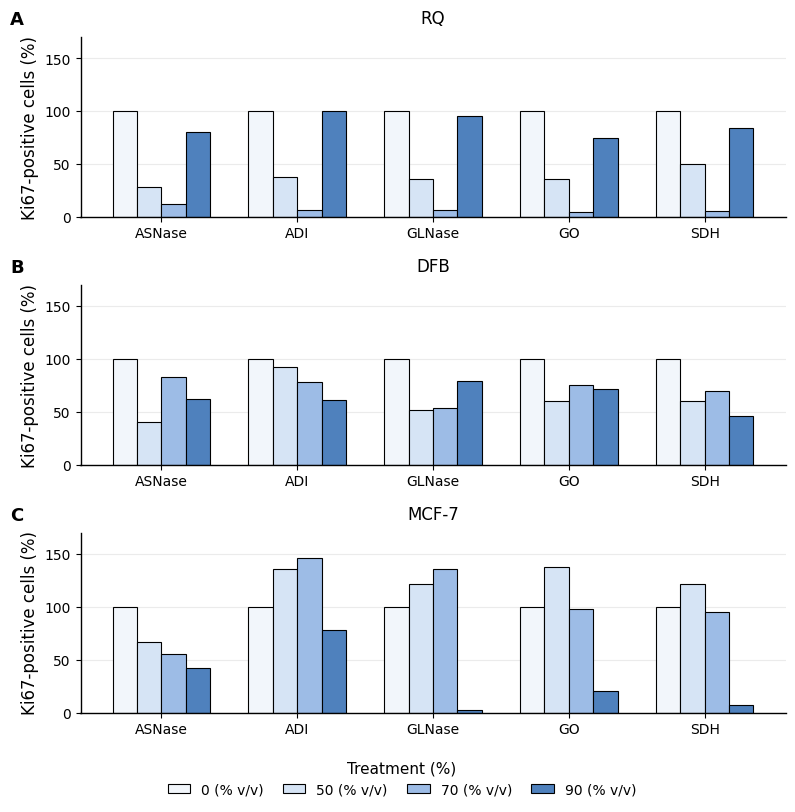

In [11]:
# ============================================================
# Subpanels by Cell line (2 columns), panel letters, legend bottom
# ============================================================

# --- Choose order of cell lines
cell_lines = list(pd.unique(df_to_process["Cell line"]))
# cell_lines = sorted(cell_lines)  # optional

enzyme_order = list(enzyme_order)
x_labels = enzyme_order

treatments = list(df_to_process["Treatment (%)"].cat.categories)
n_groups = len(treatments)

bar_width = 0.18 if n_groups >= 4 else 0.22

# --- Layout: 2 columns (vertical)
n_panels = len(cell_lines)
ncols = 1
nrows = 3

# Figure size tuned for "vertical" layout
fig_w = max(9.5, 1.20 * len(enzyme_order)) * (ncols / 2.0)
fig_h = 4.4 * nrows
fig, axes = plt.subplots(nrows, ncols, figsize=(8, 8), sharey=True)
axes = np.array(axes).reshape(-1)

x = np.arange(len(enzyme_order))

for idx, cl in enumerate(cell_lines):
    ax = axes[idx]

    # --- Filter per cell line
    df_cl = df_to_process[df_to_process["Cell line"] == cl].copy()

    # --- Summary per cell line
    summary_cl = (
        df_cl.groupby(["Enzyme", "Treatment (%)"], observed=True)
             .agg(mean_proliferation=("Ki67-positive cells (% of control)", "mean"),
                  sd_proliferation=("Ki67-positive cells (% of control)", "std"))
             .reset_index()
    )

    sum_plot = summary_cl.set_index(["Enzyme", "Treatment (%)"]).reindex(
        pd.MultiIndex.from_product([enzyme_order, treatments],
                                   names=["Enzyme", "Treatment (%)"])
    ).reset_index()

    # --- Bars + error bars
    for i, t in enumerate(treatments):
        t_float = float(t)
        sub = sum_plot[sum_plot["Treatment (%)"] == t].set_index("Enzyme").reindex(enzyme_order)

        means = sub["mean_proliferation"].values
        sds = sub["sd_proliferation"].values

        offsets = (i - (n_groups - 1) / 2) * bar_width
        xpos = x + offsets

        ax.bar(
            xpos,
            means,
            width=bar_width,
            yerr=sds,
            capsize=3,
            edgecolor="black",
            linewidth=0.8,
            color=pastel_blue.get(t_float, "#CCCCCC"),
            label=f"{t_float:g} (% v/v)" if idx == 0 else None,  # legend once
            zorder=2
        )

    else:
        letter_map = {}

    if len(letter_map) > 0:
        for i, t in enumerate(treatments):
            t_float = float(t)
            offsets = (i - (n_groups - 1) / 2) * bar_width
            xpos = x + offsets

            sub = sum_plot[sum_plot["Treatment (%)"] == t].set_index("Enzyme").reindex(enzyme_order)
            means = sub["mean_proliferation"].values
            sds = sub["sd_proliferation"].values

            for j, enz in enumerate(enzyme_order):
                L = letter_map.get((enz, t_float), "")
                if L == "" or np.isnan(means[j]):
                    continue

                y = means[j] + (0 if np.isnan(sds[j]) else sds[j]) + 4
                ax.text(xpos[j], y, L, ha="center", va="bottom",
                        fontsize=10, fontweight="bold", zorder=3)

    # --- Panel label: A, B, C...
    panel_letter = string.ascii_uppercase[idx]
    ax.text(
        -0.10, 1.05, panel_letter,
        transform=ax.transAxes,
        fontsize=13,
        fontweight="bold",
        va="bottom",
        ha="left"
    )

    # --- Axes formatting
    ax.set_title(str(cl), fontsize=12, pad=10)
    ax.set_xticks(x)
    ax.set_xticklabels(x_labels, fontsize=10)
    ax.grid(axis="y", alpha=0.25, linewidth=0.8, zorder=0)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    if idx % ncols == 0:
        ax.set_ylabel("Ki67-positive cells (%)")
    else:
        ax.set_ylabel("")

# --- Turn off unused axes
for k in range(n_panels, len(axes)):
    axes[k].axis("off")

# --- Shared Y limits with headroom
y_max = df_to_process["Ki67-positive cells (% of control)"].max()
fig_ylim = max(120, np.ceil((y_max + 20) / 10) * 10)
for ax in axes[:n_panels]:
    ax.set_ylim(0, fig_ylim)

# --- Legend bottom (global)
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles, labels,
    title="Treatment (%)",
    frameon=False,
    ncol=min(4, n_groups),
    loc="lower center",
    bbox_to_anchor=(0.5, -0.02),
    handlelength=1.6,
    columnspacing=1.4
)

# Leave space at bottom for legend
plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()



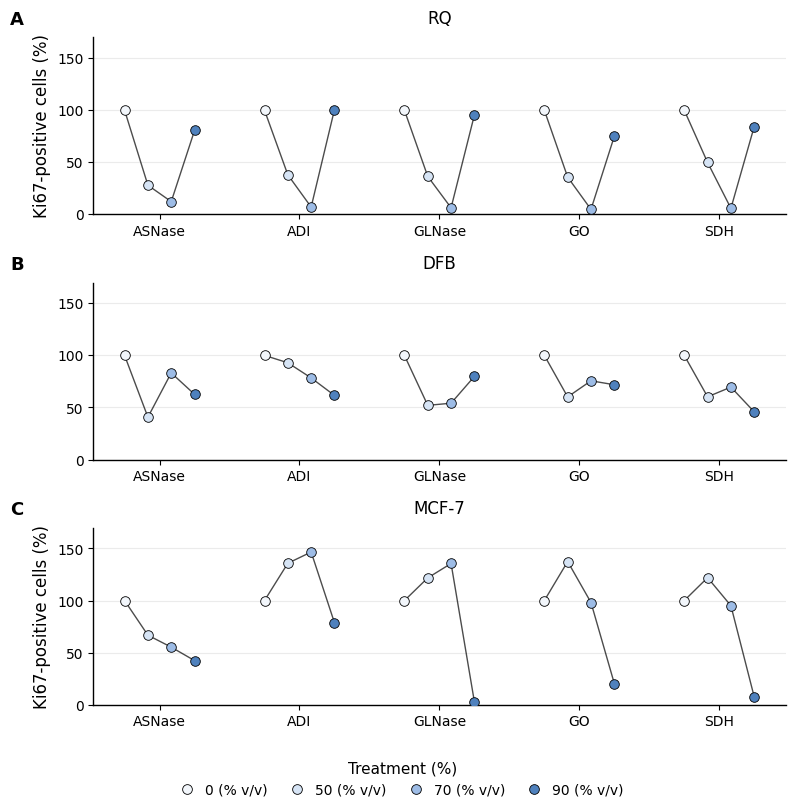

In [12]:
# ============================
# Config
# ============================
value_col = "Ki67-positive cells (% of control)"
treat_col = "Treatment (%)"
enzyme_col = "Enzyme"
cell_col = "Cell line"

enzyme_order = list(enzyme_order)  # el que ya usas
cell_lines = list(pd.unique(df_to_process[cell_col]))

# Orden tratamientos
if hasattr(df_to_process[treat_col], "cat"):
    treat_order = list(df_to_process[treat_col].cat.categories)
else:
    treat_order = sorted(df_to_process[treat_col].unique())

# Paleta (la tuya)
pastel_blue = {
    0:  "#F2F6FB",
    50: "#D6E4F5",
    70: "#9DBCE6",
    90: "#4F81BD",
}
palette = {float(t): pastel_blue.get(float(t), "#CCCCCC") for t in treat_order}

# ============================
# Layout: 2 columnas, vertical
# ============================
n_panels = len(cell_lines)
ncols = 2 if n_panels > 1 else 1
nrows = int(math.ceil(n_panels / ncols))

fig_w = max(9.5, 1.20 * len(enzyme_order)) * (ncols / 2.0)
fig_h = 4.8 * nrows
fig, axes = plt.subplots(3, 1, figsize=(8, 8), sharey=True)
axes = np.array(axes).reshape(-1)

x_base = np.arange(len(enzyme_order))

n_treat = len(treat_order)
offsets = np.linspace(-0.25, 0.25, n_treat)

for idx, cl in enumerate(cell_lines):
    ax = axes[idx]
    df_cl = df_to_process[df_to_process[cell_col] == cl].copy()

    panel_letter = string.ascii_uppercase[idx]
    ax.text(-0.12, 1.05, panel_letter, transform=ax.transAxes,
            fontsize=13, fontweight="bold", va="bottom", ha="left")

    ax.set_title(str(cl), fontsize=12, pad=10)

    for i, enz in enumerate(enzyme_order):
        sub = df_cl[df_cl[enzyme_col] == enz].copy()
        if sub.empty:
            continue

        sub[treat_col] = pd.Categorical(sub[treat_col], categories=treat_order, ordered=True)
        sub = sub.sort_values(treat_col)

        xs = []
        ys = []

        for k, t in enumerate(treat_order):
            row = sub[sub[treat_col] == t]
            if row.empty:
                continue

            y = row[value_col].values[0]
            x = x_base[i] + offsets[k]

            # Punto
            ax.scatter(
                x, y,
                s=48,
                color=palette[float(t)],
                edgecolor="black",
                linewidth=0.6,
                zorder=3
            )

            xs.append(x)
            ys.append(y)

        if len(xs) >= 2:
            ax.plot(xs, ys, color="black", linewidth=1.0, alpha=0.7, zorder=2)

    ax.set_xticks(x_base)
    ax.set_xticklabels(enzyme_order, fontsize=10)
    ax.set_xlabel("")
    ax.grid(axis="y", alpha=0.25, linewidth=0.8)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    if idx % ncols == 0:
        ax.set_ylabel("Ki67-positive cells (%)")
    else:
        ax.set_ylabel("")

for k in range(n_panels, len(axes)):
    axes[k].axis("off")

y_max = np.nanmax(df_to_process[value_col].values)
fig_ylim = max(120, np.ceil((y_max + 20) / 10) * 10)
for ax in axes[:n_panels]:
    ax.set_ylim(0, fig_ylim)

handles = []
labels = []
for t in treat_order:
    h = plt.Line2D(
        [0], [0],
        marker='o',
        linestyle='',
        markersize=7,
        markerfacecolor=palette[float(t)],
        markeredgecolor='black',
        markeredgewidth=0.6
    )
    handles.append(h)
    labels.append(f"{float(t):g} (% v/v)")

fig.legend(
    handles, labels,
    title="Treatment (%)",
    frameon=False,
    ncol=min(4, len(treat_order)),
    loc="lower center",
    bbox_to_anchor=(0.5, -0.02),
    handlelength=1.0,
    columnspacing=1.6
)

plt.tight_layout(rect=[0, 0.06, 1, 1])
plt.show()


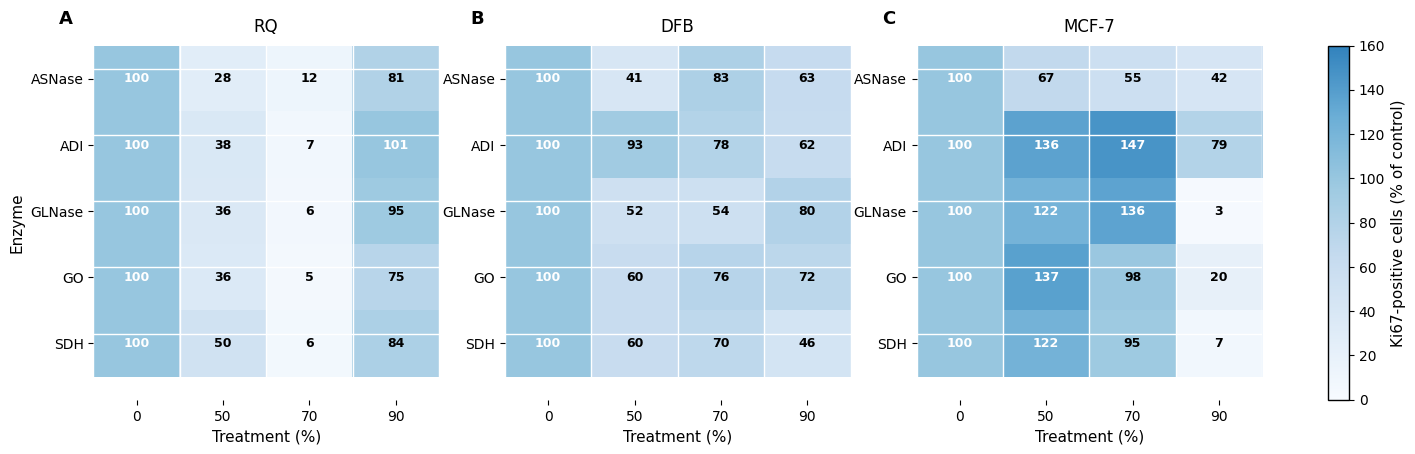

In [13]:
# ============================
# Config
# ============================
value_col = "Ki67-positive cells (% of control)"
treat_col = "Treatment (%)"
enzyme_col = "Enzyme"
cell_col = "Cell line"

cell_lines = list(pd.unique(df_to_process[cell_col]))
enzyme_order = list(enzyme_order)

# Orden tratamientos
if hasattr(df_to_process[treat_col], "cat"):
    treat_order = list(df_to_process[treat_col].cat.categories)
else:
    treat_order = sorted(df_to_process[treat_col].unique())

# ============================
# Build heatmap matrices
# ============================
heatmaps = []
for cl in cell_lines:
    df_cl = df_to_process[df_to_process[cell_col] == cl].copy()
    mat = (df_cl.pivot_table(index=enzyme_col, columns=treat_col, values=value_col, aggfunc="mean")
               .reindex(index=enzyme_order, columns=treat_order))
    heatmaps.append(mat)

# Global scaling (comparables)
global_min = np.nanmin([m.values for m in heatmaps])
global_max = np.nanmax([m.values for m in heatmaps])

# Ajusta esto si quieres forzar rango fijo (ej 0-120 o 0-150)
vmin = 0
vmax = max(120, np.ceil((global_max + 5) / 10) * 10)

# ============================
# Pastel colormap (custom)
# ============================
pastel_colors = ["#F7FBFF", "#DEEBF7", "#C6DBEF", "#9ECAE1", "#6BAED6", "#3182BD"]
cmap = LinearSegmentedColormap.from_list("pastel_blues", pastel_colors)

# ============================
# Figure layout: 1x3 + dedicated colorbar axis
# ============================
fig = plt.figure(figsize=(16.2, 4.6))
gs = fig.add_gridspec(1, 4, width_ratios=[1, 1, 1, 0.06], wspace=0.25)

axes = [fig.add_subplot(gs[0, i]) for i in range(3)]
cax = fig.add_subplot(gs[0, 3])

# Shared norm for consistent colors across panels
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

# ============================
# Plot
# ============================
for i, (ax, cl, mat) in enumerate(zip(axes, cell_lines, heatmaps)):
    data = mat.values

    im = ax.imshow(data, aspect="auto", cmap=cmap, norm=norm)

    # Panel label A/B/C
    ax.text(-0.10, 1.05, string.ascii_uppercase[i],
            transform=ax.transAxes, fontsize=13, fontweight="bold",
            va="bottom", ha="left")

    ax.set_title(str(cl), fontsize=12, pad=10)

    # Axis ticks/labels
    ax.set_xticks(np.arange(len(treat_order)))
    ax.set_xticklabels([f"{float(t):g}" for t in treat_order], fontsize=10)
    ax.set_xlabel("Treatment (%)", fontsize=11)

    ax.set_yticks(np.arange(len(enzyme_order)))
    # para que se vean las enzimas: muéstralas en TODOS los paneles
    ax.set_yticklabels(enzyme_order, fontsize=10)
    if i == 0:
        ax.set_ylabel("Enzyme", fontsize=11)

    # Subtle cell borders (paper style)
    ax.set_xticks(np.arange(-.5, len(treat_order), 1), minor=True)
    ax.set_yticks(np.arange(-.15, len(enzyme_order), 1), minor=True)
    ax.grid(which="minor", color="white", linestyle="-", linewidth=1.0)
    ax.tick_params(which="minor", bottom=False, left=False)

    # Remove spines
    for sp in ax.spines.values():
        sp.set_visible(False)

    # ============================
    # Annotate values in each cell
    # ============================
    # Texto negro/blanco dependiendo del fondo
    for r in range(data.shape[0]):
        for c in range(data.shape[1]):
            val = data[r, c]
            if np.isnan(val):
                continue

            # Contraste simple: si está alto, texto más oscuro o blanco
            # (umbral relativo)
            txt_color = "black" if (val < (vmin + 0.62*(vmax - vmin))) else "white"

            ax.text(
                c, r, f"{val:.0f}",
                ha="center", va="center",
                fontsize=9, color=txt_color, fontweight="bold"
            )

# ============================
# Colorbar (no overlap)
# ============================
cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax)
cb.set_label("Ki67-positive cells (% of control)", fontsize=11)
cb.ax.tick_params(labelsize=10)

plt.show()


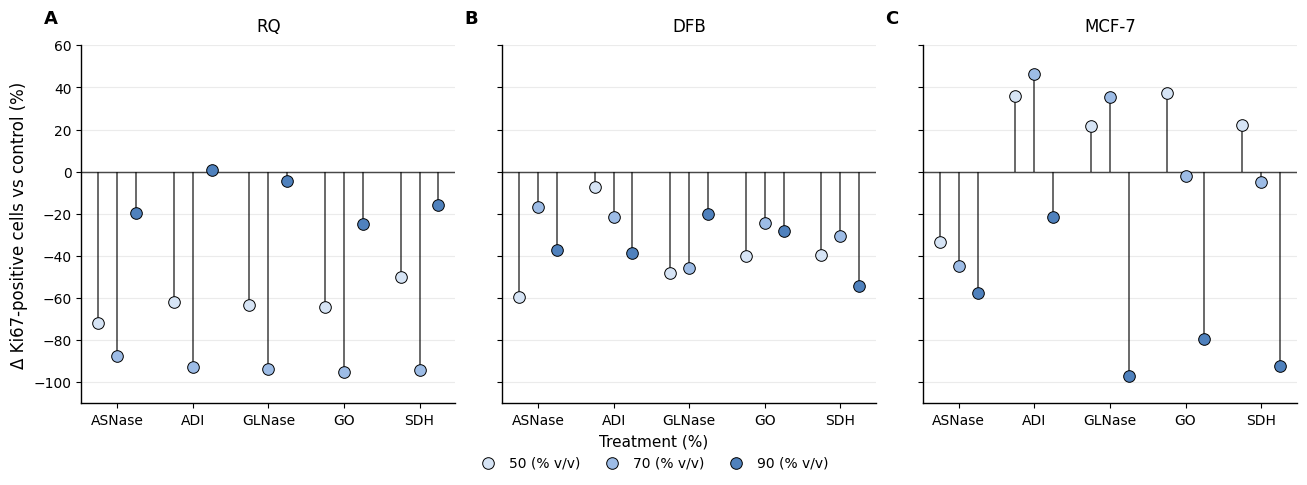

In [14]:
# ============================
# Config
# ============================
value_col = "Ki67-positive cells (% of control)"
treat_col  = "Treatment (%)"
enzyme_col = "Enzyme"
cell_col   = "Cell line"

enzyme_order = list(enzyme_order)
cell_lines = list(pd.unique(df_to_process[cell_col]))

# Orden tratamientos
if hasattr(df_to_process[treat_col], "cat"):
    treat_order = list(df_to_process[treat_col].cat.categories)
else:
    treat_order = sorted(df_to_process[treat_col].unique())

# Paleta
pastel_blue = {
    0:  "#F2F6FB",
    50: "#D6E4F5",
    70: "#9DBCE6",
    90: "#4F81BD",
}
palette = {float(t): pastel_blue.get(float(t), "#CCCCCC") for t in treat_order}

# ============================
# Δ vs control
# ============================
wide = (df_to_process
        .pivot_table(index=[cell_col, enzyme_col],
                     columns=treat_col,
                     values=value_col,
                     aggfunc="mean")
        .reindex(columns=treat_order))

t0 = treat_order[0]  # assumed 0
delta = wide.subtract(wide[t0], axis=0)

delta_long = (delta.reset_index()
                   .melt(id_vars=[cell_col, enzyme_col],
                         var_name=treat_col,
                         value_name="Delta"))

# Excluye control (Δ=0 trivial)
delta_long = delta_long[delta_long[treat_col] != t0].copy()
delta_long[treat_col] = pd.Categorical(delta_long[treat_col], categories=treat_order, ordered=True)

treat_no0 = [t for t in treat_order if t != t0]

# ============================
# Plot: 1×3
# ============================
n_panels = len(cell_lines)
fig_w = 4.4 * n_panels
fig_h = 4.8
fig, axes = plt.subplots(1, n_panels, figsize=(fig_w, fig_h), sharey=True)
if n_panels == 1:
    axes = [axes]

x = np.arange(len(enzyme_order))

# Offsets por tratamiento para separar lollipops
n_groups = len(treat_no0)
offsets = np.linspace(-0.25, 0.25, n_groups)

for i, (ax, cl) in enumerate(zip(axes, cell_lines)):
    # Panel label A/B/C
    ax.text(-0.10, 1.05, string.ascii_uppercase[i],
            transform=ax.transAxes, fontsize=13, fontweight="bold",
            va="bottom", ha="left")

    ax.set_title(str(cl), fontsize=12, pad=10)

    df_cl = delta_long[delta_long[cell_col] == cl].copy()

    # Baseline at 0
    ax.axhline(0, linewidth=1.0, color="black", alpha=0.85, zorder=1)

    for k, t in enumerate(treat_no0):
        sub = (df_cl[df_cl[treat_col] == t]
               .set_index(enzyme_col)
               .reindex(enzyme_order))

        vals = sub["Delta"].values
        xpos = x + offsets[k]

        # Stems (lollipop sticks)
        ax.vlines(
            xpos,
            0,
            vals,
            color="black",
            linewidth=1.1,
            alpha=0.75,
            zorder=2
        )

        # Heads (dots)
        ax.scatter(
            xpos,
            vals,
            s=70,
            color=palette[float(t)],
            edgecolor="black",
            linewidth=0.7,
            zorder=3,
            label=f"{float(t):g} (% v/v)" if i == 0 else None
        )

    # Axes formatting
    ax.set_xticks(x)
    ax.set_xticklabels(enzyme_order, fontsize=10)
    ax.grid(axis="y", alpha=0.25, linewidth=0.8, zorder=0)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_xlabel("")

    if i == 0:
        ax.set_ylabel("Δ Ki67-positive cells vs control (%)")
    else:
        ax.set_ylabel("")

# Global y-limits with headroom
ymin = np.nanmin(delta_long["Delta"].values)
ymax = np.nanmax(delta_long["Delta"].values)
pad = 10
ylim_lo = np.floor((ymin - pad) / 10) * 10
ylim_hi = np.ceil((ymax + pad) / 10) * 10
for ax in axes:
    ax.set_ylim(ylim_lo, ylim_hi)

# Legend bottom
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles, labels,
    title="Treatment (%)",
    frameon=False,
    ncol=min(3, len(treat_no0)),
    loc="lower center",
    bbox_to_anchor=(0.5, -0.02),
    handlelength=1.4,
    columnspacing=1.6
)

plt.tight_layout(rect=[0, 0.06, 1, 1])
plt.show()


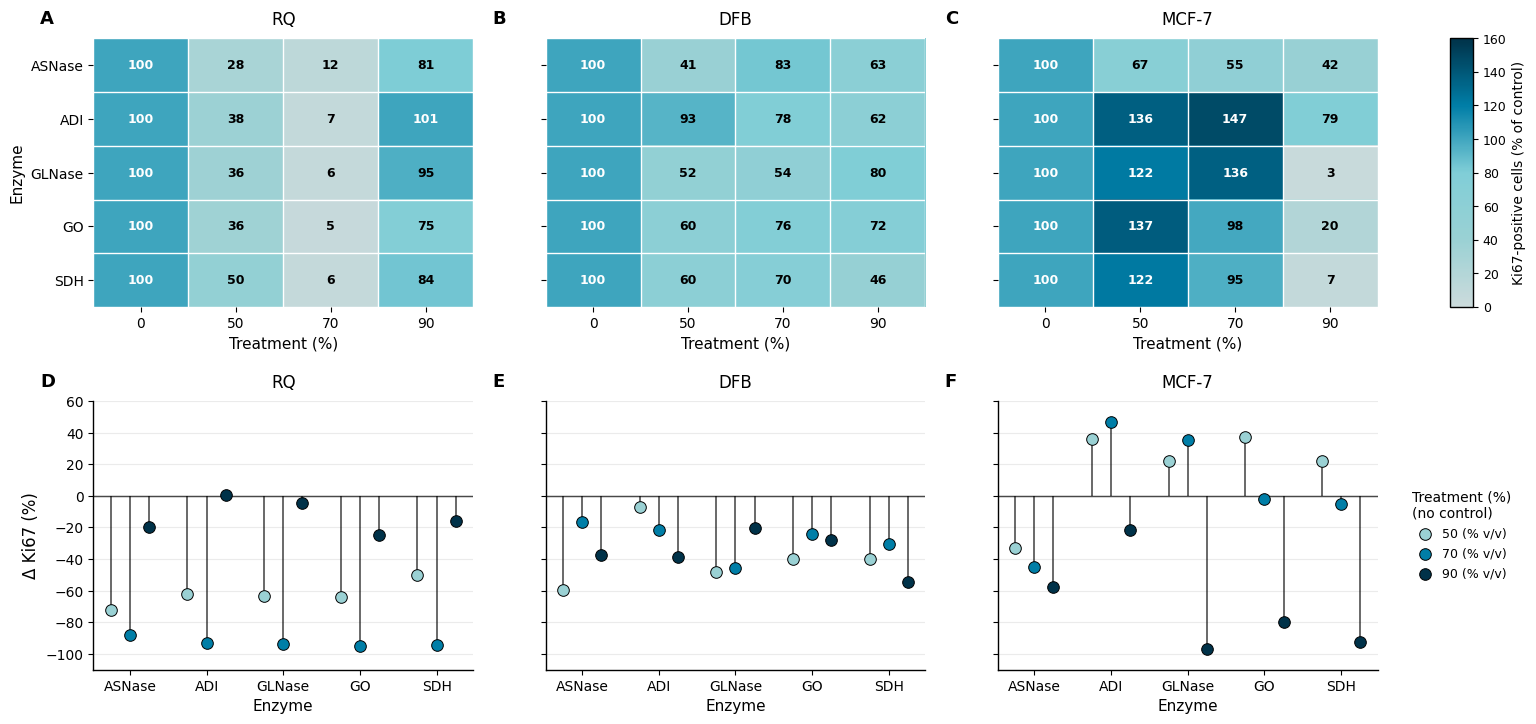

In [18]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import string
from matplotlib.colors import LinearSegmentedColormap

# ----------------------------
# Parameters (easy to tweak)
# ----------------------------
PALETTE_LIST = ["#ccdbdc","#9ad1d4","#80ced7","#007ea7","#003249"]
ANNOT_FONTSIZE = 9
PANEL_LETTER_FONTSIZE = 13

# ----------------------------
# Columns (from your notebook)
# ----------------------------
value_col = "Ki67-positive cells (% of control)"
treat_col = "Treatment (%)"
enzyme_col = "Enzyme"
cell_col  = "Cell line"

cell_lines   = list(pd.unique(df_to_process[cell_col]))
enzyme_order = list(enzyme_order)

# Treatments order
if hasattr(df_to_process[treat_col], "cat"):
    treat_order = list(df_to_process[treat_col].cat.categories)
else:
    treat_order = sorted(df_to_process[treat_col].unique())
treat_order = list(treat_order)
t0 = treat_order[0]  # assumed control (e.g., 0)
treat_no0 = [t for t in treat_order if t != t0]

# ----------------------------
# Colormaps / colors
# ----------------------------
cmap = LinearSegmentedColormap.from_list("custom_palette", PALETTE_LIST)

def sample_palette(colors, n):
    if n <= 1:
        return [colors[0]]
    idx = np.linspace(0, len(colors) - 1, n).round().astype(int)
    return [colors[i] for i in idx]

# Use consistent colors for treatments across lollipops
treat_colors = sample_palette(PALETTE_LIST, len(treat_order))
palette = {float(t): treat_colors[i] for i, t in enumerate(treat_order)}

# ----------------------------
# Heatmaps (mean) + global scaling
# ----------------------------
heatmaps = []
for cl in cell_lines:
    df_cl = df_to_process[df_to_process[cell_col] == cl].copy()
    mat = (df_cl.pivot_table(index=enzyme_col, columns=treat_col, values=value_col, aggfunc="mean")
               .reindex(index=enzyme_order, columns=treat_order))
    heatmaps.append(mat)

global_min = np.nanmin([m.values for m in heatmaps])
global_max = np.nanmax([m.values for m in heatmaps])

vmin = 0
vmax = max(120, np.ceil((global_max + 5) / 10) * 10)
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
heatmap_mappable = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

# ----------------------------
# Δ vs control for lollipops
# ----------------------------
wide = (df_to_process
        .pivot_table(index=[cell_col, enzyme_col], columns=treat_col, values=value_col, aggfunc="mean")
        .reindex(columns=treat_order))

delta = wide.subtract(wide[t0], axis=0)
delta_long = (delta.reset_index()
              .melt(id_vars=[cell_col, enzyme_col], var_name=treat_col, value_name="Delta"))
delta_long = delta_long[delta_long[treat_col] != t0].copy()
delta_long[treat_col] = pd.Categorical(delta_long[treat_col], categories=treat_order, ordered=True)

# Lollipop y-lims (global)
ymin = np.nanmin(delta_long["Delta"].values)
ymax = np.nanmax(delta_long["Delta"].values)
pad = 10
lol_ylim_lo = np.floor((ymin - pad) / 10) * 10
lol_ylim_hi = np.ceil((ymax + pad) / 10) * 10

# ----------------------------
# Figure layout: 2 rows × N cell lines (+ slim column for colorbar)
# ----------------------------
n = len(cell_lines)
fig = plt.figure(figsize=(5.2*n + 2.2, 8.2))
gs = fig.add_gridspec(
    nrows=2, ncols=n+1,
    width_ratios=[1]*n + [0.06],     # last col for colorbar
    height_ratios=[1, 1],
    wspace=0.25, hspace=0.35
)

panel_letters = list(string.ascii_uppercase)
letter_idx = 0

# ----------------------------
# Row 1: Heatmaps
# ----------------------------
heat_axes = []
for j, cl in enumerate(cell_lines):
    ax = fig.add_subplot(gs[0, j])
    heat_axes.append(ax)

    mat = heatmaps[j]
    data = mat.values

    ax.imshow(data, aspect="auto", cmap=cmap, norm=norm)

    # panel letter
    ax.text(-0.14, 1.04, panel_letters[letter_idx],
            transform=ax.transAxes, fontsize=PANEL_LETTER_FONTSIZE,
            fontweight="bold", va="bottom", ha="left")
    letter_idx += 1

    ax.set_title(str(cl), fontsize=12, pad=10)

    ax.set_xticks(np.arange(len(treat_order)))
    ax.set_xticklabels([f"{float(t):g}" for t in treat_order], fontsize=10)
    ax.set_xlabel("Treatment (%)", fontsize=11)

    ax.set_yticks(np.arange(len(enzyme_order)))
    ax.set_yticklabels(enzyme_order, fontsize=10)
    ax.set_ylabel("Enzyme", fontsize=11 if j == 0 else 0)
    if j != 0:
        ax.set_ylabel("")
        ax.set_yticklabels([])

    # grid separators
    ax.set_xticks(np.arange(-.5, len(treat_order), 1), minor=True)
    ax.set_yticks(np.arange(-.5, len(enzyme_order), 1), minor=True)
    ax.grid(which="minor", color="white", linestyle="-", linewidth=1.0)
    ax.tick_params(which="minor", bottom=False, left=False)
    for sp in ax.spines.values():
        sp.set_visible(False)

    # annotate values
    for rr in range(data.shape[0]):
        for cc in range(data.shape[1]):
            val = data[rr, cc]
            if np.isnan(val):
                continue
            txt_color = "black" if (val < (vmin + 0.62*(vmax - vmin))) else "white"
            ax.text(cc, rr, f"{val:.0f}",
                    ha="center", va="center",
                    fontsize=ANNOT_FONTSIZE, color=txt_color, fontweight="bold")

# One vertical colorbar for heatmaps (row 1 only)
cax = fig.add_subplot(gs[0, -1])
cb = fig.colorbar(heatmap_mappable, cax=cax, orientation="vertical")
cb.set_label("Ki67-positive cells (% of control)", fontsize=10)
cb.ax.tick_params(labelsize=9)

# ----------------------------
# Row 2: Lollipops
# ----------------------------
x_base = np.arange(len(enzyme_order))
n_lol = len(treat_no0)
lol_offsets = np.linspace(-0.25, 0.25, n_lol) if n_lol > 1 else np.array([0.0])

lol_handles = lol_labels = None

for j, cl in enumerate(cell_lines):
    ax = fig.add_subplot(gs[1, j])

    # panel letter
    ax.text(-0.14, 1.04, panel_letters[letter_idx],
            transform=ax.transAxes, fontsize=PANEL_LETTER_FONTSIZE,
            fontweight="bold", va="bottom", ha="left")
    letter_idx += 1

    ax.set_title(str(cl), fontsize=12, pad=10)
    ax.axhline(0, linewidth=1.0, color="black", alpha=0.85, zorder=1)

    df_lcl = delta_long[delta_long[cell_col] == cl].copy()

    for k, t in enumerate(treat_no0):
        sub = (df_lcl[df_lcl[treat_col] == t]
               .set_index(enzyme_col)
               .reindex(enzyme_order))
        vals = sub["Delta"].values
        xpos = x_base + lol_offsets[k]

        ax.vlines(xpos, 0, vals, color="black", linewidth=1.1, alpha=0.75, zorder=2)
        ax.scatter(
            xpos, vals, s=70,
            color=palette[float(t)], edgecolor="black", linewidth=0.7, zorder=3,
            label=f"{float(t):g} (% v/v)" if (j == 0) else None
        )

    ax.set_xticks(x_base)
    ax.set_xticklabels(enzyme_order, fontsize=10)
    ax.set_xlabel("Enzyme", fontsize=11)
    ax.set_ylim(lol_ylim_lo, lol_ylim_hi)
    ax.set_ylabel("Δ Ki67 (%)" if j == 0 else "")
    if j != 0:
        ax.set_yticklabels([])

    ax.grid(axis="y", alpha=0.25, linewidth=0.8, zorder=0)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    if j == 0:
        lol_handles, lol_labels = ax.get_legend_handles_labels()

# Empty axis under colorbar column
ax_empty = fig.add_subplot(gs[1, -1])
ax_empty.axis("off")

# ------------------------------------------------------------
# Leyenda VERTICAL para lollipops (columna derecha, fila 2)
# ------------------------------------------------------------
ax_leg = fig.add_subplot(gs[1, -1])
ax_leg.axis("off")

leg = ax_leg.legend(
    lol_handles,
    lol_labels,
    title="Treatment (%)\n(no control)",
    frameon=False,
    loc="center",
    ncol=1,                 # <- vertical
    handlelength=1.2,
    handletextpad=0.6,
    borderaxespad=0.0
)

plt.setp(leg.get_title(), fontsize=10)
for txt in leg.get_texts():
    txt.set_fontsize(9)


plt.tight_layout(rect=[0, 0.06, 1, 1])

fig.savefig(
    "../figures_paper/figure_proliferation_panels.png",
    dpi=600,
    bbox_inches="tight",
    facecolor="white"
)

fig.savefig(
    "../figures_paper/figure_proliferation_panels.pdf",
    bbox_inches="tight"
)

plt.show()
